In [1]:
%cd ../../hypernet

/home/z1157095/hypernet-cnn/hypernet


In [2]:
from dotenv import load_dotenv
load_dotenv()

import random
import os

In [3]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import pandas as pd
from collections import defaultdict

torch.set_default_dtype(torch.float32)

In [4]:
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [5]:
import tabular_hypernet as hp
from tabular_hypernet.mask_design import feature_variances, IncByOneTempScheduler

In [34]:
from tabular_hypernet.semisl import SSLCELossWithThreshold

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
os.environ['COMET_KEY'] = 'UXrV5UxyhTK3cyQNG6BDuc4bE'
os.environ.get("COMET_KEY")

'UXrV5UxyhTK3cyQNG6BDuc4bE'

In [8]:
seed = 5

In [9]:
dataset = hp.semisl.get_train_test_sets()

### Test concept with logistic regression

In [10]:
trainset, _ = dataset
stacked_train_set = torch.stack([x for x, _ in trainset])


In [11]:
stacked_train_set.shape

torch.Size([60000, 784])

In [12]:
stacked_test_set = torch.Tensor([y for _, y in trainset])

In [13]:
first_feature_X = stacked_train_set[:, 1].reshape(-1,1)
first_feature_y = stacked_test_set

In [14]:
first_feature_X.shape

torch.Size([60000, 1])

In [15]:
torch.all(stacked_train_set[:, 0] == stacked_train_set[:, 100])

tensor(False)

In [16]:
torch.any(stacked_train_set[:, 100] != stacked_train_set[0, 4])

tensor(True)

In [17]:
torch.var(stacked_train_set[:, 100])

tensor(0.4047)

In [18]:
model = LogisticRegression(random_state=seed).fit(first_feature_X, first_feature_y)

In [19]:
black_pixel_score = model.score(first_feature_X, first_feature_y)


In [20]:
black_pixel_score

0.11236666666666667

In [21]:
res = []
for i in tqdm(range(stacked_train_set.shape[1])):
    
    X = stacked_train_set[:, i].reshape(-1,1)
    y = stacked_test_set
    
    if torch.any(X != stacked_train_set[0, 0]):
        model = LogisticRegression(random_state=seed).fit(X, y)
        res.append(model.score(X, y))
    else:
        res.append(black_pixel_score)


 17%|███████                                  | 136/784 [03:03<29:58,  2.78s/it]/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 21%|████████▌                                | 164/784 [03:55<17:59,  1.74s/it]/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

100%|█████████████████████████████████████████| 784/784 [20:59<00:00,  1.61s/it]


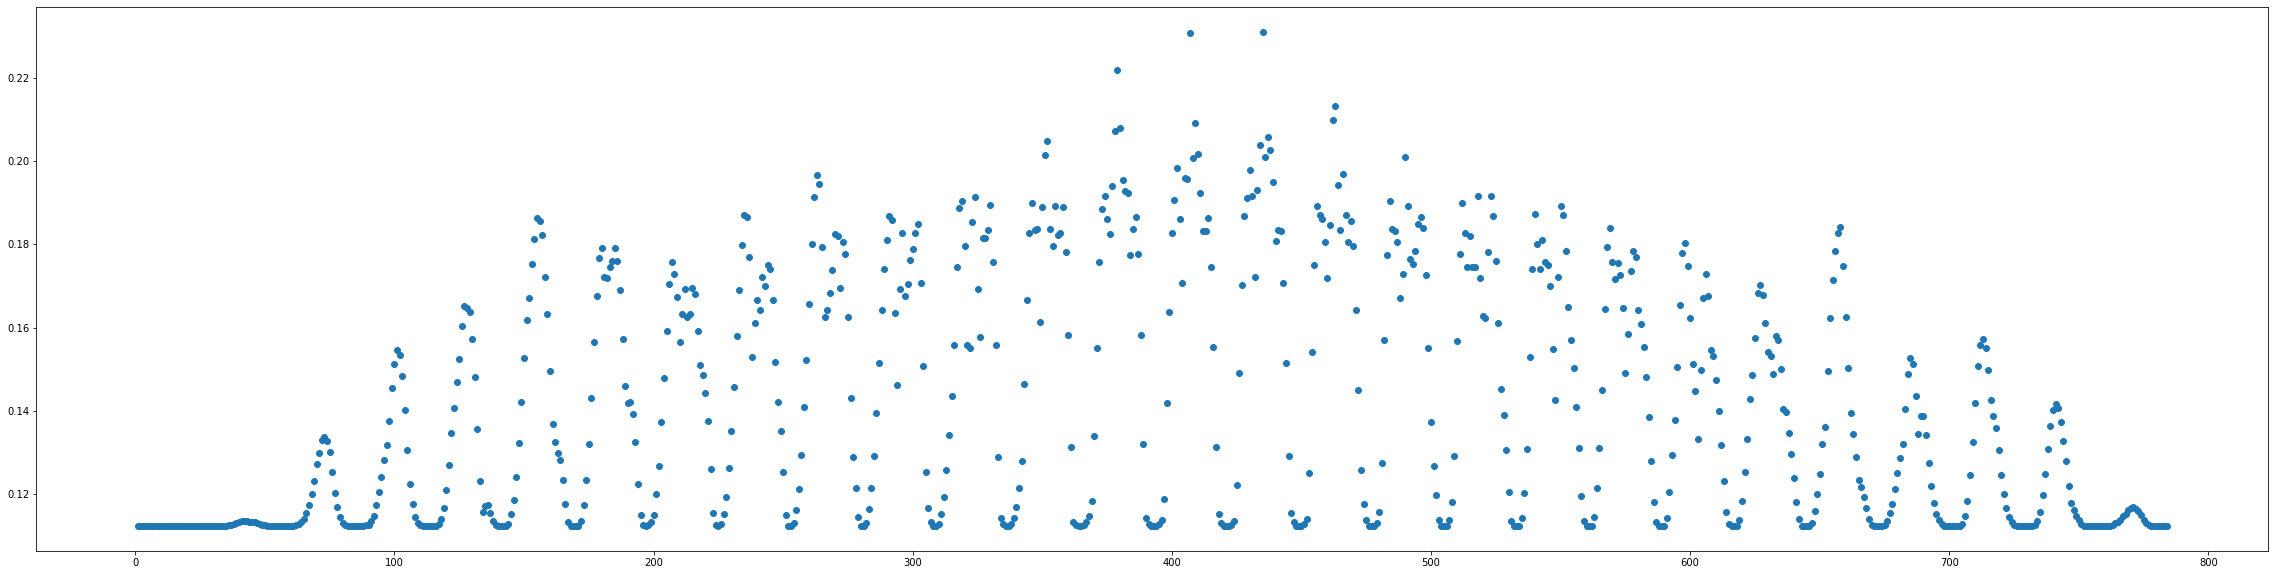

In [22]:
plt.figure(figsize=(40,10))
plt.scatter(np.arange(1,785),res)
plt.show()

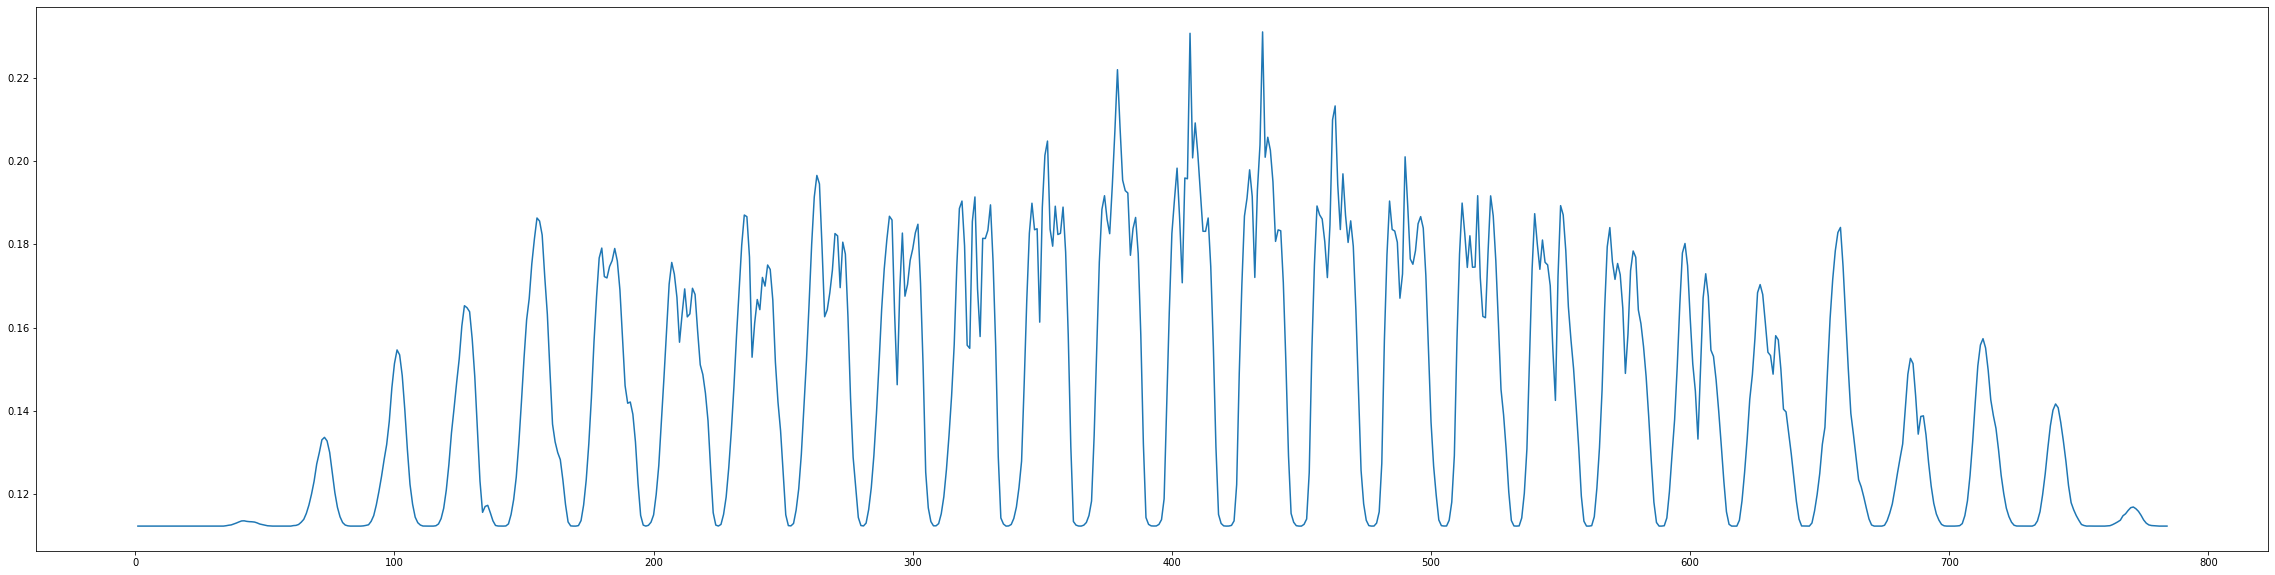

In [23]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(1,785),res)
plt.show()

In [32]:
type(res)


list

In [24]:
        
class AccMasksSelector():
    def __init__(self, feature_acc, mask_size, temp_scheduler):
        
        self.mask_size = mask_size
        
        self.feature_acc = feature_acc

        self.temp_scheduler = temp_scheduler


    def _random_choice_mask(self, mask_size):
        mask = []
        unused = np.full(self.feature_acc.shape, True)
        
        for i in range(mask_size):
            
            current_temp = self.temp_scheduler.update_temp(i)
            
            probs = torch.nn.functional.softmax(self.feature_acc[unused] / current_temp, dtype=torch.float32, dim=0).numpy()

            idx = np.random.choice(unused.nonzero()[0], 1, replace=False, p=probs)
            mask.append(idx[0])
            unused[idx[0]] = False
            
        mask = np.array(mask)
        mask.sort()
    
        return mask


    def __call__(self, model, count):
        print('Mask model', model)
        
        tmp = np.array([model.template.copy() for _ in range(count)])
        
        for i in range(count):
            self.temp_scheduler.reset_to_initial()
            
            mask = self._random_choice_mask(model.mask_size)
            tmp[i, mask] = 1
            
        masks = torch.from_numpy(tmp).to(torch.float32).to(model.device)
        print('masks shape', masks.shape)
        return masks

 

# Setup for training

In [25]:
seed = 5

In [26]:
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [27]:
mask_size = 100

In [28]:
dataset = hp.semisl.get_train_test_sets()

In [41]:
epochs = 100

masks_no = 100


results = defaultdict(list)
size = (100, 59900)


In [42]:
import tabular_hypernet

### New mask selector: Acc with temp scheduler 

### Temp scheduler 1..1: Bare Acc

In [43]:
for beta in [0.]:
    for lr in [3e-5]:
        
        temp_scheduler = IncByOneTempScheduler(1, n=mask_size, max_temp=1)
        mask_selector = AccMasksSelector(torch.tensor(res), mask_size, temp_scheduler)

        criterion = SSLCELossWithThreshold(beta=beta, threshold=None)

        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

        # dataset


        hypernet = hp.Hypernetwork(
            architecture=torch.nn.Sequential(
                torch.nn.Linear(784, 64), 
                torch.nn.ReLU(),
                torch.nn.Linear(64, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 128),
            ),
            target_architecture=[(mask_size, 20), (20, 10)],
            test_nodes=masks_no,
        ).cuda()
        
        hypernet._create_mask = None
        hypernet.test_mask = mask_selector(hypernet, hypernet.test_nodes)
        

        hypernet = hypernet.train()



        optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)

        # loaders
        sup_trainloader, unsup_trainloader, testloader = hp.semisl.get_dataloaders(dataset=dataset, size=size, batch_size=32, test_batch_size=64)
        trainloader = hp.semisl.TrainDataLoaderSemi(sup_trainloader, unsup_trainloader)

        results[size].append(hp.semisl.train_semisl(hypernet,
                                          optimizer,
                                          criterion,
                                          (trainloader, testloader), 
                                          size,
                                          epochs,
                                          masks_no,
                                          changing_beta=None,
                                          log_to_comet=True,
                                          shuffled_masks=False,
                                          project_name="mask-selection",
                                          tags=['acc-mask-sel'],
                                          description="""
                                          masks are selected based on feature accuracies with softmax and temp
                                          """,
                                        log_params={'seed': seed, 'temp scheduler': 'inc by one 1..1', 'max_temp' : 1}
                                        ))


torch.Size([1, 128])
Mask model Hypernetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (output_layer): Linear(in_features=128, out_features=2230, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
masks shape torch.Size([100, 784])
!! log to comet is True 



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/abulenok/mask-selection/478a80d87f36440889546c4a2054fc56

100%|███████████████████████████████████████████████████████████████████| 100/100 [32:25<00:00, 19.45s/it, loss=1.75, test_acc=72.4]
COMET ERROR: Error sending a notification, make sure you have opted-in for notifications
COMET INFO: Uploading 1 metrics, params and output messages


### Temp scheduler 1..11

In [44]:
for beta in [0.]:
    for lr in [3e-5]:
        
        temp_scheduler = IncByOneTempScheduler(1, n=mask_size, max_temp=11)
        mask_selector = AccMasksSelector(torch.tensor(res), mask_size, temp_scheduler)

        criterion = SSLCELossWithThreshold(beta=beta, threshold=None)

        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

        # dataset


        hypernet = hp.Hypernetwork(
            architecture=torch.nn.Sequential(
                torch.nn.Linear(784, 64), 
                torch.nn.ReLU(),
                torch.nn.Linear(64, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 128),
            ),
            target_architecture=[(mask_size, 20), (20, 10)],
            test_nodes=masks_no,
        ).cuda()
        
        hypernet._create_mask = None
        hypernet.test_mask = mask_selector(hypernet, hypernet.test_nodes)
        

        hypernet = hypernet.train()



        optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)

        # loaders
        sup_trainloader, unsup_trainloader, testloader = hp.semisl.get_dataloaders(dataset=dataset, size=size, batch_size=32, test_batch_size=64)
        trainloader = hp.semisl.TrainDataLoaderSemi(sup_trainloader, unsup_trainloader)

        results[size].append(hp.semisl.train_semisl(hypernet,
                                          optimizer,
                                          criterion,
                                          (trainloader, testloader), 
                                          size,
                                          epochs,
                                          masks_no,
                                          changing_beta=None,
                                          log_to_comet=True,
                                          shuffled_masks=False,
                                          project_name="mask-selection",
                                          tags=['acc-mask-sel'],
                                          description="""
                                          masks are selected based on feature accuracies with softmax and temp
                                          """,
                                        log_params={'seed': seed, 'temp scheduler': 'inc by one 1..11', 'max_temp' : 11}
                                        ))


torch.Size([1, 128])
Mask model Hypernetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (output_layer): Linear(in_features=128, out_features=2230, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
masks shape torch.Size([100, 784])
!! log to comet is True 



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/abulenok/mask-selection/5c69ca3e09ec4561a2a668c6372a3bcb

100%|███████████████████████████████████████████████████████████████████| 100/100 [32:08<00:00, 19.28s/it, loss=1.76, test_acc=71.5]
COMET ERROR: Error sending a notification, make sure you have opted-in for notifications
COMET INFO: Uploading 1 metrics, params and output messages


### Temp scheduler 1..20

In [45]:
for beta in [0.]:
    for lr in [3e-5]:
        
        temp_scheduler = IncByOneTempScheduler(1, n=mask_size, max_temp=20)
        mask_selector = AccMasksSelector(torch.tensor(res), mask_size, temp_scheduler)

        criterion = SSLCELossWithThreshold(beta=beta, threshold=None)

        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

        # dataset


        hypernet = hp.Hypernetwork(
            architecture=torch.nn.Sequential(
                torch.nn.Linear(784, 64), 
                torch.nn.ReLU(),
                torch.nn.Linear(64, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 128),
            ),
            target_architecture=[(mask_size, 20), (20, 10)],
            test_nodes=masks_no,
        ).cuda()
        
        hypernet._create_mask = None
        hypernet.test_mask = mask_selector(hypernet, hypernet.test_nodes)
        

        hypernet = hypernet.train()



        optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)

        # loaders
        sup_trainloader, unsup_trainloader, testloader = hp.semisl.get_dataloaders(dataset=dataset, size=size, batch_size=32, test_batch_size=64)
        trainloader = hp.semisl.TrainDataLoaderSemi(sup_trainloader, unsup_trainloader)

        results[size].append(hp.semisl.train_semisl(hypernet,
                                          optimizer,
                                          criterion,
                                          (trainloader, testloader), 
                                          size,
                                          epochs,
                                          masks_no,
                                          changing_beta=None,
                                          log_to_comet=True,
                                          shuffled_masks=False,
                                          project_name="mask-selection",
                                          tags=['acc-mask-sel'],
                                          description="""
                                          masks are selected based on feature accuracies with softmax and temp
                                          """,
                                        log_params={'seed': seed, 'temp scheduler': 'inc by one 1..20', 'max_temp' : 20}
                                        ))


torch.Size([1, 128])
Mask model Hypernetwork(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (output_layer): Linear(in_features=128, out_features=2230, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
masks shape torch.Size([100, 784])
!! log to comet is True 



COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/abulenok/mask-selection/5ff02ecbc46a4508a506b6868fcfb53e

100%|███████████████████████████████████████████████████████████████████| 100/100 [31:52<00:00, 19.12s/it, loss=1.76, test_acc=71.5]
COMET ERROR: Error sending a notification, make sure you have opted-in for notifications
COMET INFO: Uploading 1 metrics, params and output messages


### No feature selection

In [46]:
for beta in [0.]:

    for lr in [3e-5]:


        criterion = SSLCELossWithThreshold(beta=beta, threshold=None)

        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

        # dataset


        hypernet = hp.Hypernetwork(
            architecture=torch.nn.Sequential(
                torch.nn.Linear(784, 64), 
                torch.nn.ReLU(),
                torch.nn.Linear(64, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 128),
            ),
            target_architecture=[(mask_size, 10), (10, 10)],
            test_nodes=masks_no,
        ).cuda()
        
        hypernet = hypernet.train()



        optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)

        # loaders
        sup_trainloader, unsup_trainloader, testloader = hp.semisl.get_dataloaders(dataset=dataset, size=size, batch_size=32, test_batch_size=64)
        trainloader = hp.semisl.TrainDataLoaderSemi(sup_trainloader, unsup_trainloader)

        results[size].append(hp.semisl.train_semisl(hypernet,
                                          optimizer,
                                          criterion,
                                          (trainloader, testloader), 
                                          size,
                                          epochs,
                                          masks_no,
                                          changing_beta=None,
                                          shuffled_masks=False,
                                          log_to_comet=True,
                                          project_name="mask-selection",
                                          tags=['acc-mask-sel'],
                                          description="""
                                          masks are selected based on feature variance with softmax and temp
                                          """,
                                        log_params={'seed': seed, 'temp scheduler': 'none', 'mask selection': 'none'}
                                        ))


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


torch.Size([1, 128])
!! log to comet is True 



COMET INFO: Experiment is live on comet.ml https://www.comet.com/abulenok/mask-selection/4ed66b8827ed4ec5bd7af2b3023a361f

100%|███████████████████████████████████████████████████████████████████| 100/100 [31:51<00:00, 19.12s/it, loss=1.75, test_acc=71.8]
COMET ERROR: Error sending a notification, make sure you have opted-in for notifications
COMET INFO: Uploading 1 metrics, params and output messages
